### Insights from Additional Domain Research

* The following fields are depracated or no longer supported and should be excluded from the model so it doesn't cause breaking of the pipeline in the future. networkDomain, networkLocation, isMobile

This also points to a need for upstream feature drift reslilience.

Additional Features we could capture which were not in the original consideration set for the conversion model include (per user)

* Number of TrueDirect sessions, count of non-null sessions in the IsTrueDirect column

* Number of adwordsSessions (sessions which had some ad interaction), count of how many visits for which at least one of the adwords or adcontent columns are populated

* PCA components of source feature. First creating sparse counts of referral source per user, then performing PCA on the user level dataset. May need to standardize once it's tallied up this way, before creating components. Whatever conclusion we reach from applying this to the training set would need to be applied to the validation and test set as well, but cannot create components altogether as this risks data leakage. Source chosen as it is a high cardinality, fully populated column which we originally discarded due to high cardinality. The same can be said of the Country feature. 

### Example of PCA on Source Feature (not yet on user level dataset)

In [4]:
import pandas as pd

In [5]:
gstore = pd.read_csv("/Users/aoluwolerotimi/Datasets/train_dejsonified.csv")

/var/folders/z1/1zds15w97_g7_fhs4_83dc3m0000gn/T/ipykernel_61162/3136096564.py:1: DtypeWarning: Columns (2,54) have mixed types. Specify dtype option on import or set low_memory=False.
  gstore = pd.read_csv("/Users/aoluwolerotimi/Datasets/train_dejsonified.csv")


In [6]:
gstore.dtypes

channelGrouping                         object
date                                     int64
fullVisitorId                           object
sessionId                               object
socialEngagementType                    object
visitId                                  int64
visitNumber                              int64
visitStartTime                           int64
continent                               object
subContinent                            object
country                                 object
region                                  object
metro                                   object
city                                    object
cityId                                  object
networkDomain                           object
latitude                                object
longitude                               object
networkLocation                         object
browser                                 object
browserVersion                          object
browserSize  

In [8]:
gstore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   channelGrouping                      903653 non-null  object 
 1   date                                 903653 non-null  int64  
 2   fullVisitorId                        903653 non-null  object 
 3   sessionId                            903653 non-null  object 
 4   socialEngagementType                 903653 non-null  object 
 5   visitId                              903653 non-null  int64  
 6   visitNumber                          903653 non-null  int64  
 7   visitStartTime                       903653 non-null  int64  
 8   continent                            903653 non-null  object 
 9   subContinent                         903653 non-null  object 
 10  country                              903653 non-null  object 
 11  region       

In [3]:
source_df = pd.DataFrame.copy(gstore['source'])

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

In [5]:
encoder = OneHotEncoder(sparse_output= False)

In [6]:
encoded_source = encoder.fit_transform(source_df.to_numpy().reshape(-1, 1))

In [7]:
encoded_df = pd.DataFrame(encoded_source, index=source_df.index, columns=encoder.get_feature_names_out())

In [9]:
# going from 380 potential sources, and source is a fully populated column
pca = PCA(n_components=20)
pca.fit(encoded_df)

PCA(n_components=20)

In [10]:
pca.explained_variance_ratio_

array([0.46175465, 0.26118638, 0.12723651, 0.04128312, 0.02515321,
       0.01346282, 0.00810481, 0.00647967, 0.00518889, 0.00481465,
       0.00407228, 0.00342697, 0.00317968, 0.00293208, 0.00264091,
       0.00237903, 0.00236165, 0.00230856, 0.00226216, 0.00173574])

In [11]:
import matplotlib.pyplot as plt
import numpy as np

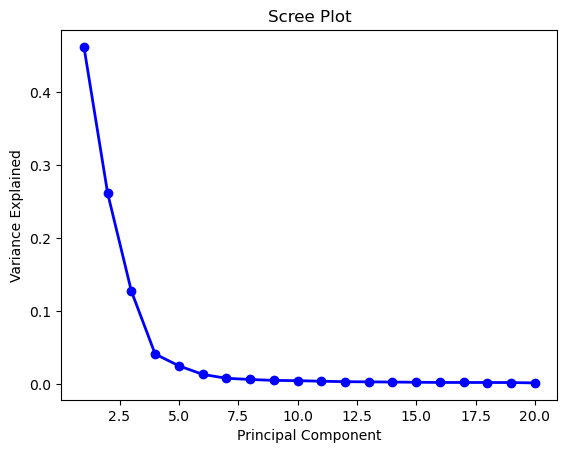

In [12]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [8]:
# elbow is at 3 components. note, after this is aggregated to user level and then standardized, elbow may move
pca = PCA(n_components=3)
X_source_pca = pca.fit_transform(encoded_df)
# I believe we'd need to do this for train and test separately to not have data leakage through the PCA??

In [9]:
n_components = X_source_pca.shape[1]  # Get the number of components
column_names = [f"PC_Source_{i}" for i in range(n_components)]  
# Create the DataFrame with the transformed data and column names
X_source_df = pd.DataFrame(data=X_source_pca, columns=column_names, index=encoded_df.index)